# Computing planet fluxes

The photometry package contains two classes to compute the flux of the planets that are used as primary calibrators in (sub-)mm astronomy.

For the gas giants Uranus and Neptune, the photometry package provides the GiantPlanet class. It uses the ESA models by Moreno et al. for the brightness temperature, and relies on the JPL Horizons for the ephemeris. The GiantPlanet class delivers planet spectra (i.e. photometry BasicSpectrum objects) computed for the requested date. 

For Mars, photometry provides the Mars class, that allows to query the model of Lellouche and Amri through their web interfaces. This class does not return spectra, but only monochromatic fluxes of the planet for a given date. 

This notebook illustrate how to use these two classes.

In [1]:
%matplotlib inline
import numpy as np
import photometry as pt
from astropy import units as u
from astropy.coordinates import Angle
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib import gridspec


We will cover the following points:

 * <a href='#GiantPlanet'>Using the GiantPlanet class</a>
   * <a href='#GiantPlanet'>Using the GiantPlanet class</a>
   * <a href='#NIKA_photometric_system'>Planet fluxes for NIKA(2) photometric system</a>
   * <a href='#ModelComparison'>Comparing different models</a>
   * <a href='#UnderTheHood'>A look under the hood</a>
 * <a href='#Mars'>Using the Mars class</a>

<a id='GiantPlanet'></a> 

## Using the GiantPlanet class
### Basic usage

In [2]:
# initialize the planets
uranus = pt.GiantPlanet('Uranus')
neptune = pt.GiantPlanet('Neptune')

In [3]:
# compute neptune solid angle for one date, and uranus for two
neptune.set_dates(Time('2017-04-20T00:00:00.0'))
neptune_omega = neptune.solid_angle()
uranus.set_dates(Time(['2015-10-15T00:00:00.0','2017-04-20T00:00:00.0']))
uranus_omega =  uranus.solid_angle()

In [4]:
print("neptune solid angle: {}".format(neptune_omega))
print("uranus solid angle: {}".format(uranus_omega))

neptune solid angle: 9.049157598694219e-11 rad2
uranus solid angle: [2.50169742e-10 2.06371244e-10] rad2


In [5]:
spec_uranus = uranus.spectral_irradiance()
spec_neptune_2017 = neptune.spectral_irradiance()

In [6]:
nika2mm = pt.Passband(file='2mm.NIKA2.pb')
nika1mmH = pt.Passband(file='1mmH.NIKA2.pb')
nika1mmV = pt.Passband(file='1mmV.NIKA2.pb')

Here we will use the fnu_ab() method to compute the planet fluxes. Basically AB convention quote the flux that a source that was generating the same response as our objcet would have with a spectrum $S^0_\nu$=cte. 

$\int T_{\nu} S^0_{\nu} d\nu = \int S_{\nu} T_{\nu} d\nu$

Where $T_{\nu}$ is the system response. 

So that:

$  S^0_{\nu} = \frac{\int S_{\nu} T_{\nu} d\nu}{\int T_{\nu} d\nu}$



In [7]:
nika2mm.fnu_ab?

In [8]:
print("Uranus fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_uranus).to(u.Jy)[1],
                     nika2mm.fnu_ab(spec_uranus).to(u.Jy)[1],
                     nika1mmV.fnu_ab(spec_uranus).to(u.Jy)[1]))
# Recall that 2017 is the second spectrum..

Uranus fluxes in 2017:
1mmH: 36.046 Jy | 2mm: 14.579 Jy | 1mmV: 36.642 Jy


In [9]:
# Print all the uranus fluxes
nika2mm.fnu_ab(spec_uranus).to(u.Jy)

<Quantity [17.67365698, 14.57943932] Jy>

In [10]:
print("Neptune fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)))


Neptune fluxes in 2017:
1mmH: 15.387 Jy | 2mm: 6.650 Jy | 1mmV: 15.629 Jy


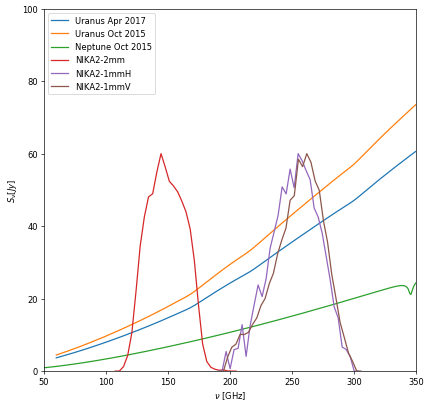

In [11]:
fig1 = plt.figure(1, (8,8), 60)
plt.plot(spec_uranus.nu(u.GHz), (spec_uranus.fnu(u.Jy))[1,:], label='Uranus Apr 2017')
plt.plot(spec_uranus.nu(u.GHz), (spec_uranus.fnu(u.Jy))[0,:], label='Uranus Oct 2015')
plt.plot(spec_neptune_2017.nu(u.GHz), spec_neptune_2017.fnu(u.Jy), label='Neptune Oct 2015')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu} [Jy]$')
plt.axis([50, 350, 0, 100])
plt.plot(nika2mm.nu(u.GHz), nika2mm.response()*60., label='NIKA2-2mm')
plt.plot(nika1mmH.nu(u.GHz), nika1mmH.response()*60., label='NIKA2-1mmH')
plt.plot(nika1mmV.nu(u.GHz), nika1mmV.response()*60., label='NIKA2-1mmV')
plt.legend(loc='upper left', frameon=True)





<a id='NIKA_photometric_system'></a>

### NIKA (2) photometric systems

In NIKA and NIKA2 a different convention for quoting fluxes is used:

$ S_{\nu_{0}}= S_{\nu_{0}}^{c} \frac{\int S_{\nu} T_{\nu} d \nu }{\int S_{\nu}^{c} T_{\nu} d \nu} $

Where $S_{\nu}$ is the spectrum of the object, and $S_{\nu}^{c}$ is the spectrum of the calibrator, and $\nu_{0}$ is the reference frequency of the band. In other word, the quoted flux is the the flux that the would planet have at the reference frequency $\nu_{0}$ in order to generate the same response from the instrument as the object.

So the flux used for the planet are the one at the reference frequency. Here is how to obtain them:

In [12]:
print(nika1mmH.xref(u.GHz))
print(spec_uranus.fnu_nu(nika1mmH.xref(u.GHz)).to(u.Jy))

260.0 GHz
[45.99858651 37.94537836] Jy


In [13]:
print(nika1mmV.xref(u.GHz))
print(spec_uranus.fnu_nu(nika1mmV.xref(u.GHz)).to(u.Jy))

260.0 GHz
[45.99858651 37.94537836] Jy


In [14]:
print(nika2mm.xref(u.GHz))
print(spec_uranus.fnu_nu(nika2mm.xref(u.GHz)).to(u.Jy))

150.0 GHz
[17.80937575 14.69139711] Jy


<a id='ModelComparison'></a>

### On the planetary models atmosphere.

If you have read the docstring of the GiantPlanet class, you may have realized that there are more than one model for each planet. The computations we did for both planets used the  version 4 of ESA models for Herschel calibration of 'esa4' for short. There is a version 5 for both planets, but it has been approved only for neptune. Let's check the differences for a few passbands. 

In [15]:
# Load the model
neptunev5 = pt.GiantPlanet('Neptune', model_version='esa5')

In [16]:
neptunev5.set_dates(Time('2017-04-20T00:00:00.0'))
neptunev5_omega = neptune.solid_angle()
print('neptunev5_omega = {:0.03g}. It should be equal to neptunev4_omega {:0.3g} because we are using the same ephemeris in both cases'.format(neptunev5_omega, neptune_omega))


neptunev5_omega = 9.05e-11 rad2. It should be equal to neptunev4_omega 9.05e-11 rad2 because we are using the same ephemeris in both cases


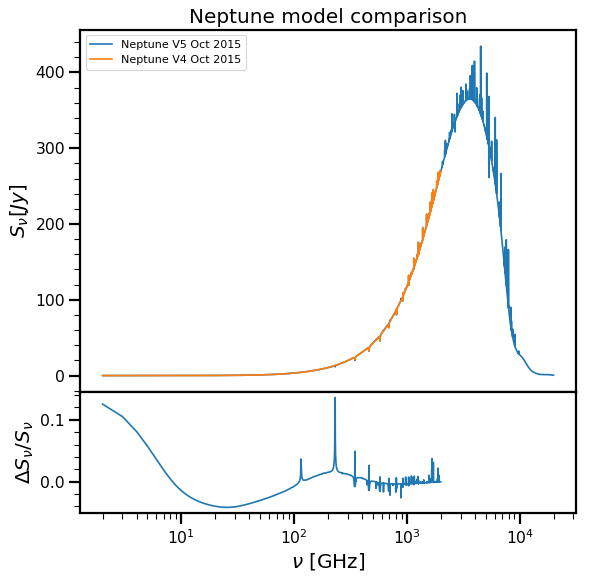

In [17]:
spec_neptune_v5 = neptunev5.spectral_irradiance()

fig = plt.figure(1, (8,8), 80)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(gs[0])
ax1.set_xscale("log")
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=2, which='major')
ax1.tick_params('both', length=5, width=1, which='minor')
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.set_title('Neptune model comparison', fontdict={'fontsize':18})
plt.plot(spec_neptune_v5.nu(u.GHz), spec_neptune_v5.fnu(u.Jy), label='Neptune V5 Oct 2015')
plt.plot(spec_neptune_2017.nu(u.GHz), spec_neptune_2017.fnu(u.Jy), label='Neptune V4 Oct 2015')
plt.ylabel(r'$S_{\nu} [Jy]$', fontsize=18)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.autoscale(False)  
ax1.set_xlim([1, 1000])
plt.legend(loc='upper left')


ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.minorticks_on()
ax2.tick_params('both', length=10, width=2, which='major')
ax2.tick_params('both', length=5, width=1, which='minor')
ax2.tick_params(axis='both', which='major', labelsize=14)

# Note on how we interpolate the spectrum of the second model at the frequencies of the first
# by using the fnu_nu() method instead of the fnu()
plt.plot(spec_neptune_2017.nu(u.GHz), (spec_neptune_2017.fnu(u.Jy)-\
         spec_neptune_v5.fnu_nu(spec_neptune_2017.nu(u.GHz)))/spec_neptune_2017.fnu(u.Jy))
         
         
plt.ylabel(r'$\Delta S_{\nu}/ S_{\nu}$', fontsize=18)
plt.xlabel(r'$\nu$ [GHz]', fontsize=18)

for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(2)
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
labels = ax2.get_yticklabels()
(labels[-1]).set_visible(False)




Note that both models have not the same frequency coverage. 

In [18]:
# Differences in the NIKA2 passbands
print("Neptune fluxes in V4:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)))

print("Neptune fluxes in V5:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_v5).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_v5).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_v5).to(u.Jy)))

print("Differences:")
print('1mmH: {0:0.03f}% | 2mm: {1:0.03f}% | 1mmV: {2:0.03f}%'.
          format((nika1mmH.fnu_ab(spec_neptune_v5).to(u.Jy) - \
                  nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy)) / \
                 nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy)*100.,
                (nika2mm.fnu_ab(spec_neptune_v5).to(u.Jy)- \
                 nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy)) / \
                 nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy) * 100,
                     (nika1mmV.fnu_ab(spec_neptune_v5).to(u.Jy) - \
                 nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)) / \
                  nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy) * 100))




Neptune fluxes in V4:
1mmH: 15.387 Jy | 2mm: 6.650 Jy | 1mmV: 15.629 Jy
Neptune fluxes in V5:
1mmH: 15.087 Jy | 2mm: 6.596 Jy | 1mmV: 15.344 Jy
Differences:
1mmH: -1.946% | 2mm: -0.810% | 1mmV: -1.824%


<a id='UnderTheHood'></a>

### Under the hood:

#### Planet solid angle:

$r_{p-a} = r_{eq} \sqrt{1 - e^{2} cos^{2} \phi}$

where $\phi$ is the sub observer latitude.

$e = \sqrt{\frac{r_{eq}^{2} - r_{p}^{2}}{r_{eq}^2}}$

So we have the geometric radius:

$r_{gm} = \sqrt{r_{eq} r_{p-a}}$

And finally the solid angle under which uranus is seen is:

$\Omega = \pi \left(\frac{r_{gm}}{d}\right)^{2}$ 

where $d$ is the distance planet to observer.

See for example Bendo et al. (2013) http://adsabs.harvard.edu/abs/2013MNRAS.433.3062B but with an error in their eq 12 where $r_{eq}$ should be at the denominator, or Planck Collaboration et al. (2017) Planck intermediate results LII: Planet flux densities.


#### Planet spectral irradiance:

We use ESA V4 model that tabulates the brightness temperature of Uranus as a function of the frequency. From this we can compute the incident spectral irradiance on the detector:

$ S_{\nu} = \Omega \times \frac{ 2 h \nu^{3}}{c^{2}} \frac{1}{e^{\frac{h \nu}{k T_{b}}} -1}$

The file contains a value of $S_{\nu}$ computed using 3.5" of angular diameter for Uranus and 2.3" for Neptune.

Alternativeley, we could use the Rayleigh-Jean temperature where:

$ S_{\nu} = \Omega \times \frac{2  \nu^{2} k T_{RJ}}{c^{2}} $

The code implement the full derivation.

Since both the 1mmH and 1mmV have the same reference frequency, the planet flux is the same for both. This is why the convention adopted was changed. An other possibility would have to have to different reference frequencies for the two bands, acknowledging that they are different. Their difference though is not that large: when taking into account the atmosphere, passband change with elevation as can be seen in the irampassband_howto notebook.

In [19]:
# Let's check the code:
check_ang = Angle(3.5/2. * u.arcsec)
check_omega = np.pi * check_ang**2
uranus_test = uranus.spectral_irradiance(solid_angle=check_omega)
check_ang = Angle(2.3/2. * u.arcsec)
check_omega = np.pi * check_ang**2
neptune_test = neptune.spectral_irradiance(solid_angle=check_omega)

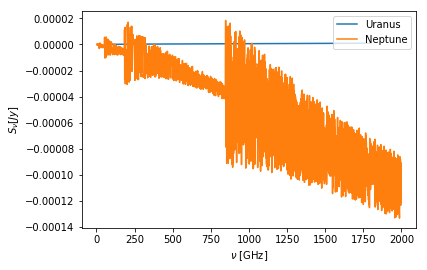

In [20]:
plt.plot(uranus.model['wave'].quantity, 
         (uranus.model['flux'].quantity - uranus_test.fnu_nu(uranus.model['wave'].quantity))/
          uranus.model['wave'].quantity, label='Uranus')
plt.plot(neptune.model['wave'].quantity, 
         (neptune.model['flux'].quantity - neptune_test.fnu_nu(neptune.model['wave'].quantity))/
          neptune.model['wave'].quantity, label='Neptune')

plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu} [Jy]$')
plt.legend(loc='upper right')
# OK


How important is it to take into account the shape of the planet. A easier computation would be to just scale the model spectrum computed for 3.5" with the angular diameter, without taking the aspect ratio into account. We can look at the effect of this.

In [21]:
# let's look at the variation over 10 years, one point every 10 days
times = Time(np.arange(Time('2010-01-01T12:00:00').jd, 
                       Time('2020-01-01T12:00:00').jd, 20), format='jd')

neptune.set_dates(times)
uranus.set_dates(times)

True

In [22]:
from scipy import interpolate

uranus_int = interpolate.interp1d(uranus.ephemeris['JulDate'], \
                                  uranus.ephemeris['AngDiam'], kind='linear')
    
omega_simple_uranus = np.pi * (uranus_int(times.jd)*u.arcsec / 2)**2

omega_full_uranus = uranus.solid_angle()

In [23]:
neptune_int = interpolate.interp1d(neptune.ephemeris['JulDate'], \
                                  neptune.ephemeris['AngDiam'], kind='linear')
    
omega_simple_neptune = np.pi * (neptune_int(times.jd)*u.arcsec / 2)**2

omega_full_neptune = neptune.solid_angle()

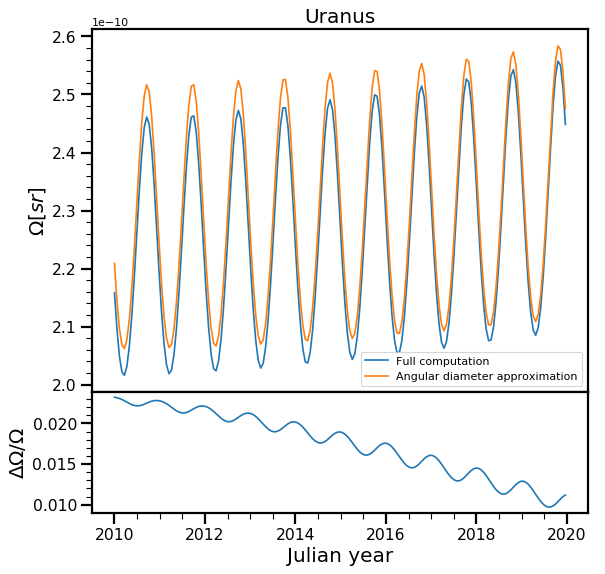

In [24]:
fig = plt.figure(1, (8,8), 80)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(gs[0])

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=2, which='major')
ax1.tick_params('both', length=5, width=1, which='minor')
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.set_title('Uranus', fontdict={'fontsize':18})
plt.plot(times.jyear, omega_full_uranus, label='Full computation')
plt.plot(times.jyear, omega_simple_uranus.to(u.sr), label='Angular diameter approximation')
plt.ylabel(r'$\Omega [sr]$', fontsize=18)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.autoscale(False)    
plt.legend(loc='lower right')
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.minorticks_on()
ax2.tick_params('both', length=10, width=2, which='major')
ax2.tick_params('both', length=5, width=1, which='minor')
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.plot(times.jyear, (omega_simple_uranus.to(u.sr)-omega_full_uranus)/omega_full_uranus)
plt.ylabel(r'$\Delta \Omega/ \Omega$', fontsize=18)
plt.xlabel(r'Julian year',fontsize=18)


for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(2)
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
labels = ax2.get_yticklabels()
(labels[-1]).set_visible(False)



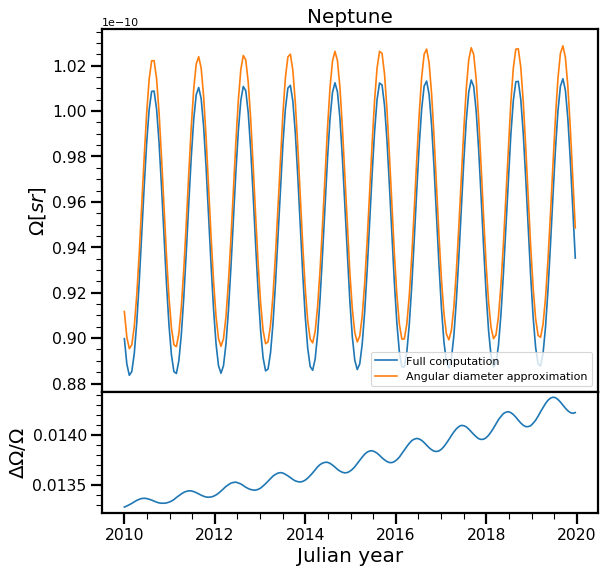

In [25]:
fig = plt.figure(1, (8,8), 80)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(gs[0])

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=2, which='major')
ax1.tick_params('both', length=5, width=1, which='minor')
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.plot(times.jyear, omega_full_neptune, label='Full computation')
plt.plot(times.jyear, omega_simple_neptune.to(u.sr), label='Angular diameter approximation')
plt.ylabel(r'$\Omega [sr]$', fontsize=18)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.set_title('Neptune', fontdict={'fontsize':18})
ax1.autoscale(False)    
plt.legend(loc='lower right')
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.minorticks_on()
ax2.tick_params('both', length=10, width=2, which='major')
ax2.tick_params('both', length=5, width=1, which='minor')
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.plot(times.jyear, (omega_simple_neptune.to(u.sr)-omega_full_neptune)/omega_full_neptune)
plt.ylabel(r'$\Delta \Omega/ \Omega$', fontsize=18)
plt.xlabel(r'Julian year',fontsize=18)


for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(2)
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
labels = ax2.get_yticklabels()
(labels[-1]).set_visible(False)



For both planets, taking into account the ellipsoidal shape lead to differences of a few percent.

<a id='Mars'></a>

## Using the Mars class

The photometry package provides the Mars class that allows to query the Lellouche and Amri model V1.3 over the web. This model takes into account seasonal variations, and the size of the planet in the sky compared to the beam size. But it does not provide a full spectrum for the planet. Because the queries are slow, the values of each query are stored in an internal SQLite database, so that if a query is repeated, the locally stored values will be used. The photometry package comes with an already populated database. 

In [26]:
mars = pt.Mars()

In [27]:
print(mars)

-----------------------------------------------------------------------------
Mars model Version 1.3 of E.Lellouche and H. Amri
Local values stored in /Users/haussel/work/python/photometry/data/planets/Mars/marsdata.db
Telecope: Iram30m
For a HPBW at 300 GHz of 9.5 arcsec
Instrument: NIKA2
Model frequencies: 150.0, 260.0, 1600.0, 3200.0 GHz
Roughness: 12
Penetration length: 12
Dielectric constant: 2.25
-----------------------------------------------------------------------------


Here we have created the Mars object with its default setup for NIKA2 at the Iram 30m telescope. The telescope value will set the beam size et 300 GHz (9.5" in the case of the 30m). The instrument value sets the model frequencies that will be queried (150 and 260 GHz, the two others comes for free). All the other values are the default ones suggested on the model web page: http://www.lesia.obspm.fr/perso/emmanuel-lellouch/mars/tedate_v1.2_100pts.php

We can take a look at the values already present in the model database:

In [28]:
mars.dumpdb()

datetime,hpbw@300GHz,roughness,penlen,dielec,Rapp,nu,hpbw,fillfact,fnu,Tb,Fmb,AveTbMb,TmbRJ
,arcsec,deg,,,arcsec,GHz,arcsec,,Jy,K,Jy,K,K
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2018-01-17T00:00:00.000,9.5,12.0,12.0,2.25,2.577,150.0,19.0,20.108,69.432,208.215,67.75,208.394,10.186
2018-01-17T00:00:00.000,9.5,12.0,12.0,2.25,2.577,260.0,10.962,7.038,210.747,212.914,196.279,213.854,29.51
2018-01-17T00:00:00.000,9.5,12.0,12.0,2.25,2.577,1600.0,1.781,1.003,7311.129,225.587,1426.436,251.531,214.462
2018-01-17T00:00:00.000,9.5,12.0,12.0,2.25,2.577,3200.0,0.891,1.0,24892.388,229.449,1272.604,260.58,191.334
2018-01-17T12:00:00.000,9.5,12.0,12.0,2.25,2.577,150.0,19.0,20.103,69.19,207.458,67.508,207.621,10.15
2018-01-17T12:00:00.000,9.5,12.0,12.0,2.25,2.577,260.0,10.962,7.036,210.198,212.332,195.729,213.231,29.427
2018-01-17T12:00:00.000,9.5,12.0,12.0,2.25,2.577,1600.0,1.781,1.003,7317.142,225.703,1424.779,251.278,214.213
2018-01-17T12:00:00.000,9.5,12.0,12.0,2.25,2.577,3200.0,0.891,1.0,24931.818,229.679,1268.985,260.02,190.79


We are mostly interested in the total flux values for Mars, the column fnu. Let's check for a value already in the base: at 150 GHz, at the date of 2018-01-18

In [29]:
print(mars.fnu(150*u.GHz, Time('2018-01-18T00:00:00')))

70.467 Jy


Let's try a date not in the database:

In [30]:
print(mars.fnu(150*u.GHz, Time('2018-01-23T00:00:00')))

75.002 Jy


When we executed this, the model was query, and it took some time. However, the 260 GHz value was obtained at the same time, so that the follwoing call is quick:

In [31]:
print(mars.fnu(260*u.GHz, Time('2018-01-23T00:00:00')))

227.205 Jy
